__Load packages for plotting and data handling__

In [1]:
using Plots,LaTeXStrings, StatsPlots
using DataFrames
using DataFramesMeta
using Interact
using GLM
using Distributions
using CSV

gr(fmt="png")

┌ Info: Recompiling stale cache file C:\Users\stephan\.julia\compiled\v1.0\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file C:\Users\stephan\.julia\compiled\v1.0\StatsPlots\SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file C:\Users\stephan\.julia\compiled\v1.0\DataFrames\AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file C:\Users\stephan\.julia\compiled\v1.0\DataFramesMeta\2xRTO.ji for DataFramesMeta [1313f7d8-7da2-5740-9ea0-a2ca25f37964]
└ @ Base loading.jl:1190


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/09d89566e721198c81c7dc3b76d1160c29ef4bbd-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/09d89566e721198c81c7dc3b76d1160c29ef4bbd-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1192
┌ Info: Recompiling stale cache file C:\Users\stephan\.julia\compiled\v1.0\CSV\HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1190


Plots.GRBackend()

__Add worker processes for parallel computation__

In [2]:
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

__Load simulation routines__

In [6]:
@everywhere include("src/mcmc.jl")

---

__Onsager critical temperature__

In [4]:
Tc = 2/log(1+sqrt(2));

### Autocorrelation

To get correct estimates for the observables of interest, one has to make sure the samples taken are statistically independent.
Therefore one cannot sample every timestep, but needs to wait for a certain amount of time until the correlations have subsided.

As the system is brought closer to the critical point it becomes correlated on longer timescales. This phenomenon know as __critical slowing down__. It is a consequence of the growing correlation length as the critical point is approached.

In [8]:
@time ts = let Tmax=10000,L=100
mapreduce(vcat, [4.,2.5,2.26,2.1,2.2]) do T
    df = DataFrame()
    df[:t] = collect(1:Tmax-1)
    df[:L] = L
    df[:T] = T

    ts = metropolis_timeseries(L,1/T,Tmax*L^2)
    ts .-=  mean(ts)

    df[:autocor] = map(1:Tmax-1) do t
        1.0/(Tmax-t+1)*sum(ts[1:Tmax-t+1].*ts[t:Tmax])
    end
    df
end
end;

 42.532539 seconds (2.00 M allocations: 5.697 GiB, 1.40% gc time)


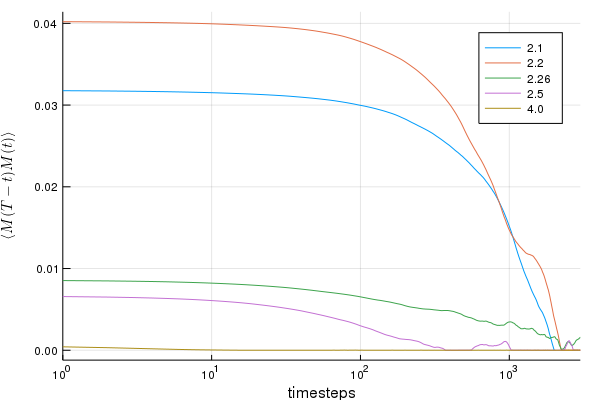

In [9]:
@df @where(ts,:autocor.>0.)  plot(:t, :autocor, group=:T, xscale=:log10, xlim=(1,3000),
    xlabel="timesteps", ylabel=L"\langle M(T-t)M(t)\rangle")

### Timeseries & histogram of the magnetisation

In [56]:
@time  magnetization = let Tmax=50000,L=100
mapreduce(vcat, [4.,2.5,Tc,2.0,1.0]) do T
    df = DataFrame()
    df[:t] = collect(1:Tmax)
    df[:L] = L
    df[:T] = T

    df[:m] = metropolis_timeseries(L,1/T,Tmax*L^2,L^2,0)
    df
end
end;

271.956514 seconds (10.85 k allocations: 29.612 MiB, 0.08% gc time)


In [33]:
magnetization = CSV.read("example_data\\magnetization-ts-N100.tsv",delim='\t');

In [62]:
CSV.write("example_data\\magnetization-ts-N100.tsv",magnetization,delim='\t');

CSV.Sink{Void,DataType}(    CSV.Options:
        delim: '	'
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false'
        internstrings: true, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "example_data\\magnetization-ts-N100.tsv", 8, true, String["t", "L", "T", "m"], 4, false, Val{false})

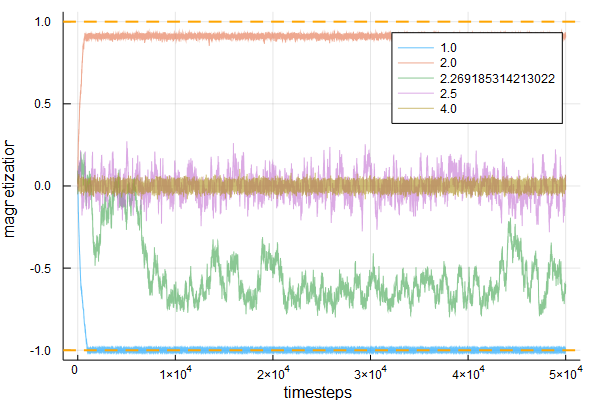

In [75]:
@df magnetization plot(:t,(:m), group=:T, xlabel="timesteps", ylabel="magnetization", label=:T, alpha=0.6)
hline!([-1.,+1.], lw=2, lab="", ls=:dash, c=:orange)

In [1]:
@df magnetization density(:m, group=:T,alpha=0.6, normalize=true, size=(800,600), lw=3)

LoadError: [91mUndefVarError: @df not defined[39m

### Simulation

In [ ]:
obs = DataFrame(Float64,0,7)
names!(obs,[:L,:T,:e,:e2,:m,:m2,:m4])

## Temperature range
Ts = linspace(2.6,2.0,50)
Ls = [10,30,50,100]

for L in Ls
@everywhere begin state=randomConfiguration($L); end
@time map(pmap(Ts) do T
        println("T=$T")
            
#       result = run_wolff(L, 1/T,0.;Tmax=10*10^3,sweep=100*L^2,poll_interval=1)
#       result = run_metropolis(L, 1/T,0.;Tmax=50*10^3*L^2,sweep=1000*L^2,poll_interval=10*L^2)
            
        sweep!(state,1000*(L^2),1/T,0.)            
        result = _run_metropolis!(state, 1/T,0.;Tmax=1000*10^3*L^2,poll_interval=100*L^2)

        E = result[1]
        E2 = result[2]
        mag = result[3]
        mag2 = result[4]
        mag4 = result[5]
        [L,T,E,E2,mag,mag2,mag4]'
    end) do row
        #println(row)
        push!(obs,row);
    end;
end
   
# obs[:t] = obs[:T]-Tc;


__Calculate susc. & heat capacity__

In [16]:
obs[:c] = (obs[:e2].-obs[:e].^2)./(obs[:T].^2)./obs[:L].^2;
obs[:chi] = (obs[:m2].-obs[:m].^2)./obs[:T].*obs[:L].^2;

__Save/load data__

In [17]:
CSV.write("example_data\\metropolis04-N10-30-50-100-longWait.tsv", obs, delim="\t")

LoadError: [91mTypeError: Type: in typeassert, expected Char, got String[39m

In [15]:
obs = CSV.read("example_data\\metropolis04-N10-30-50-100-longWait.tsv", delim="\t");

### Analysis

__Estimate the critical temperature from the heat capacity__

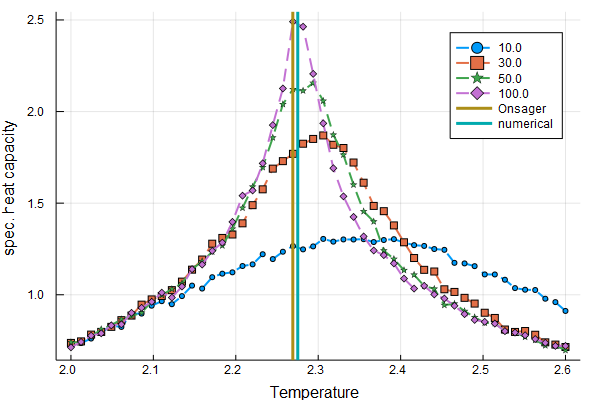

In [9]:
@df obs plot(:T, abs.(:c), group=:L, legend=true,line=(:dash, 2.), marker=(:auto,3), xlabel="Temperature", ylabel="spec. heat capacity")
vline!([Tc Tc+0.006],lab=["Onsager" "numerical"], lw=3)

In [18]:
# Estimated critical temperature
Tcnum = Tc + 0.006

2.275185314213022

__Define reduced temperature__

In [19]:
obs[:t] = obs[:T]-Tcnum;

__Plot observables__

(div
  Widgets.Widget{:slider}(DataStructures.OrderedDict{Symbol,Any}(:changes=>Observables.Observable{Int64}("ob_03", 0, Any[WebIO.SyncCallback(WebIO.Scope("knockout-component-ef3d88af-3b6b-48ec-abc8-9423b30cd43c", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["L"], Dict{Symbol,Any}(Pair{Symbol,Any}(:className, "interact "),Pair{Symbol,Any}(:style, Dict{Any,Any}(Pair{Any,Any}(:padding, "5px 10px 0px 10px")))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"text-align:right;width:18%"))), 2), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:max, 4),Pair{Symbol,Any}(:min, 1),Pair{Symbol,Any}(:attributes, Dict{Any,Any}(Pair{Any,Any}(:type, "range"),Pair{Any,Any}(Symbol("data-bind"), "numericValue: internalvalue, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}"))),Pair{Symbol,Any}(:step, 1),Pair{Symbol,Any}(:className, "slider slider is-fullwidth"),Pair{Symbol,Any}(:style, Dict{Any,Any}())), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"flex-grow:1; margin: 0 2%"))), 1), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("data-bind"=>"text: displayedvalue"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"width:18%"))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"display:flex; justify-content:center; align-items:center;"))), 7), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("changes", (Observables.Observable{Int64}(#= circular reference @-7 =#), nothing)),Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("internalvalue", (Observables.Observable{Int64}("ob_02", 2, Any[WebIO.SyncCallback(WebIO.Scope(#= circular reference @-7 =#), WebIO.SyncCallback(WebIO.Scope(#= circular reference @-8 =#), WebIO.#37))]), nothing)),Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("value", (Observables.Observable{Float64}("ob_01", 30.0, Any[WebIO.SyncCallback(WebIO.Scope(#= circular reference @-7 =#), WebIO.SyncCallback(WebIO.Scope(#= circular reference @-8 =#), WebIO.#37)), Observables.g]), nothing))), Set{String}(), nothing, Any["knockout"=>"C:\\Users\\stephan\\.julia\\v0.6\\Knockout\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\stephan\\.julia\\v0.6\\Knockout\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\stephan\\.julia\\v0.6\\InteractBase\\src\\..\\assets\\all.js", "C:\\Users\\stephan\\.julia\\v0.6\\InteractBase\\src\\..\\assets\\style.css", "C:\\Users\\stephan\\.julia\\v0.6\\InteractBulma\\src\\..\\assets\\main.css"], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"
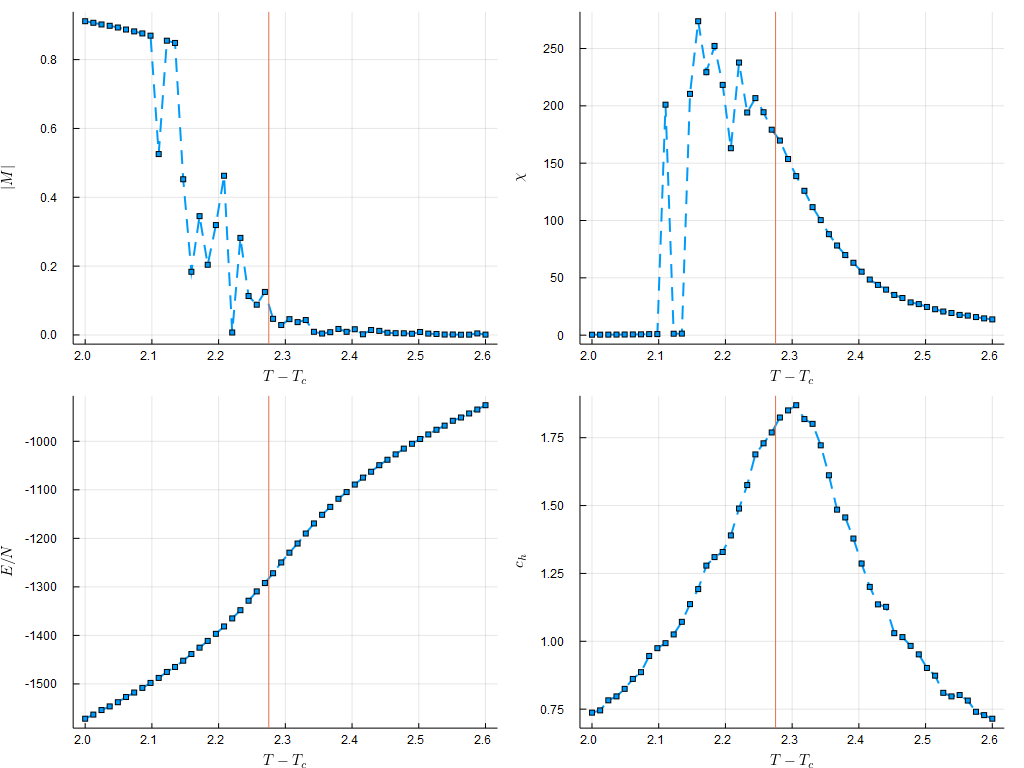
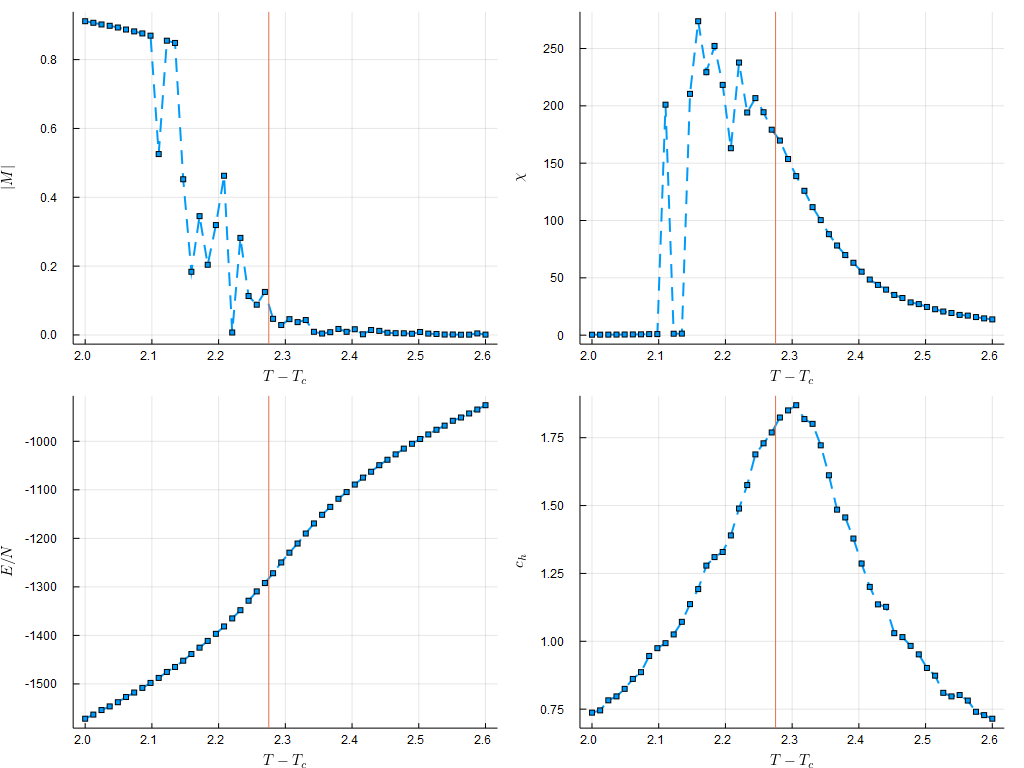

In [9]:
@manipulate for L in levels(obs[:L])
@df obs[obs[:L].==L,:] plot(:T, [abs.(:m) :chi :e :c],
    group=:L, layout=4, legend=false, size=(1024,768),
    marker=:square,ms=2., line=(:dash, 2.), ylabel=[L"\vert M \vert" L"\chi" L"E/N" L"c_h"])
xlabel!(L"T-T_c")
vline!([[Tcnum] [Tcnum] [Tcnum] [Tcnum]],lab="Onsager")
end

__Split observables in sets above/below $T_c$ __

In [20]:
obs_above = obs[(obs[:t].>0) .& (obs[:L].==100),:];
obs_below = obs[(obs[:t].<0) .& (obs[:L].==100),:];

### Critical exponents

__Magnetization__

In [21]:
log_obs = @select(obs_below,logt=log.(abs.(:t)),logm=log.(abs.(:m)));

In [22]:
beta_regr = lm(@formula(logm ~ logt),log_obs[3:end,:]) # neglect the two datapoints closest to Tc

StatsModels.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: logm ~ 1 + logt

Coefficients:
              Estimate  Std.Error t value Pr(>|t|)
(Intercept)  0.0711246 0.00321985 22.0894   <1e-14
logt          0.122521 0.00151357 80.9485   <1e-24


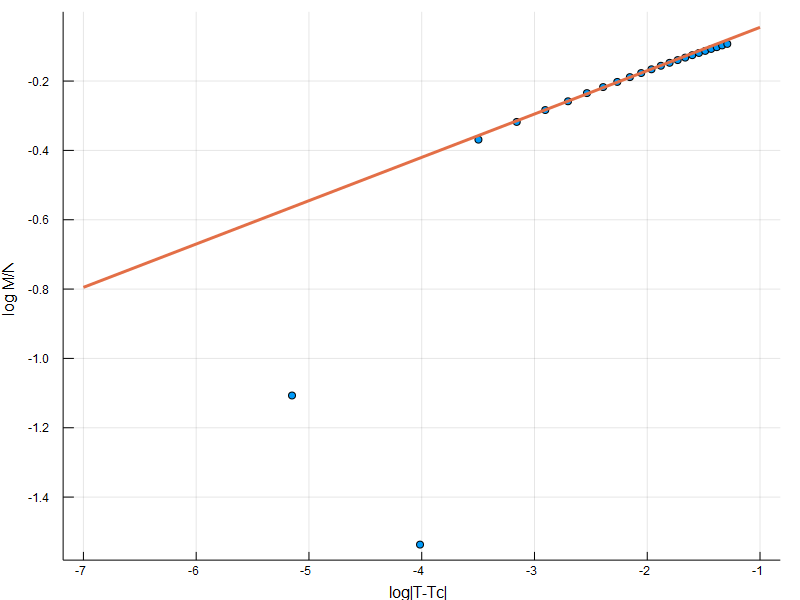

In [23]:
scatter(log.(abs.(obs_below[:t])),log.(abs.(obs_below[:m])), xlabel="log|T-Tc|", ylabel="log M/N",legend=false,size=(800,600))
#scatter!(log.(abs.(obs_above[:t])),log.(abs.(obs_above[:m])), xlabel="log|T-Tc|", ylabel="log\\chi",legend=false)

plot!(-7.:-1,t->t*1/8+0.08, lw=3) # exact exponent 1/8
#plot!(-5.:-1,t->abs(t)*7/4-11)

__Suscpetibility__

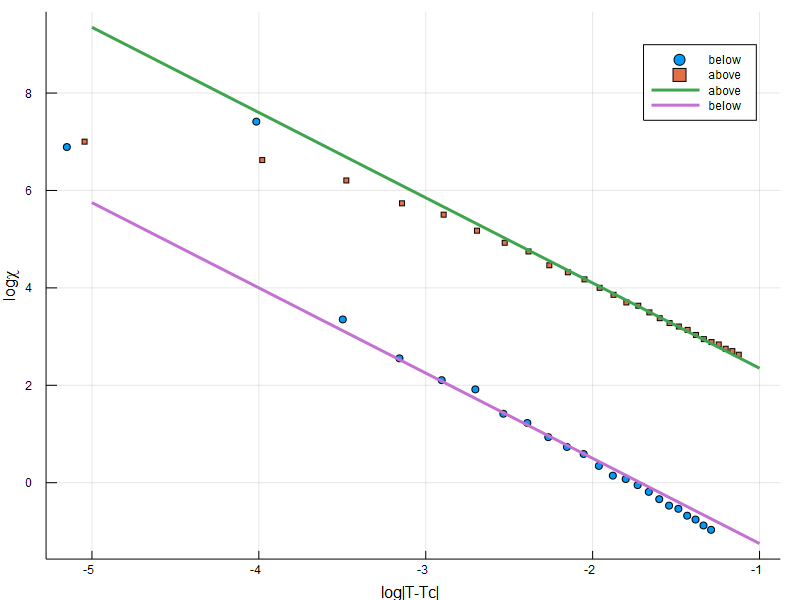

In [24]:
scatter(log.(abs.(obs_below[:t])),log.(abs.(obs_below[:chi])), xlabel="log|T-Tc|", legend=true, marker=:auto, lab="below",size=(800,600))
scatter!(log.(abs.(obs_above[:t])),log.(abs.(obs_above[:chi])), xlabel="log|T-Tc|", ylabel="log\\chi", marker=(2,:auto), lab="above")

plot!(-5.:-1,t->-t*7/4+0.6, lab="above", lw=3)
plot!(-5.:-1,t->-t*7/4-3., lab="below", lw=3)

__Heat capacity__

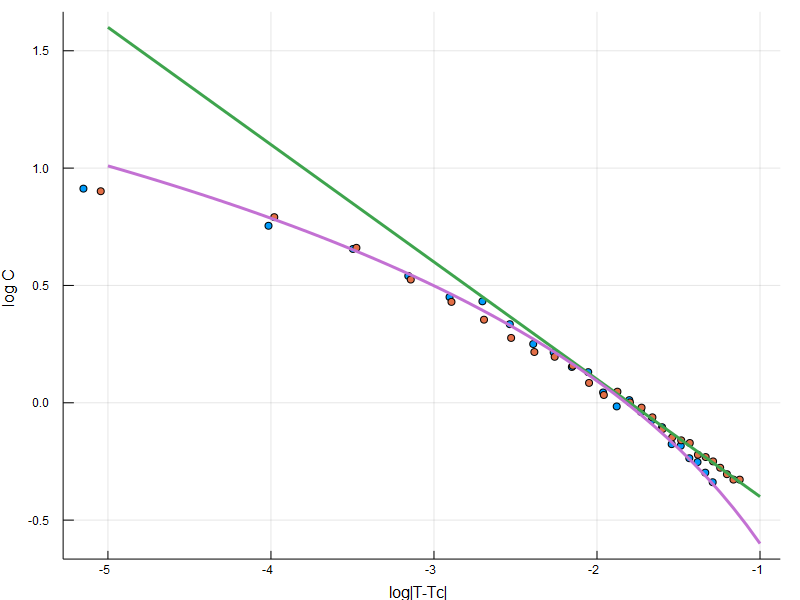

In [25]:
scatter(log.(abs.(obs_below[:t])),log.(obs_below[:c]), xlabel="log|T-Tc|", legend=false, size=(800,600))
scatter!(log.(abs.(obs_above[:t])),log.(obs_above[:c]), xlabel="log|T-Tc|", ylabel="log C",legend=false)
#
plot!(linspace(-5,-1,50),t->-1/2*t-0.9,lw=3.)
plot!(linspace(-5,-1,50),t->1.*log(-t)-0.6,lw=3.)


### Addendum

__Binder cumulants__

In the unordered phase the distribution of $m$ is a Gaussian around $0$ of width $~1/\sqrt{t}$, while deep in the ordered phase it is _two_ Gaussians peaked at $\pm 1$.



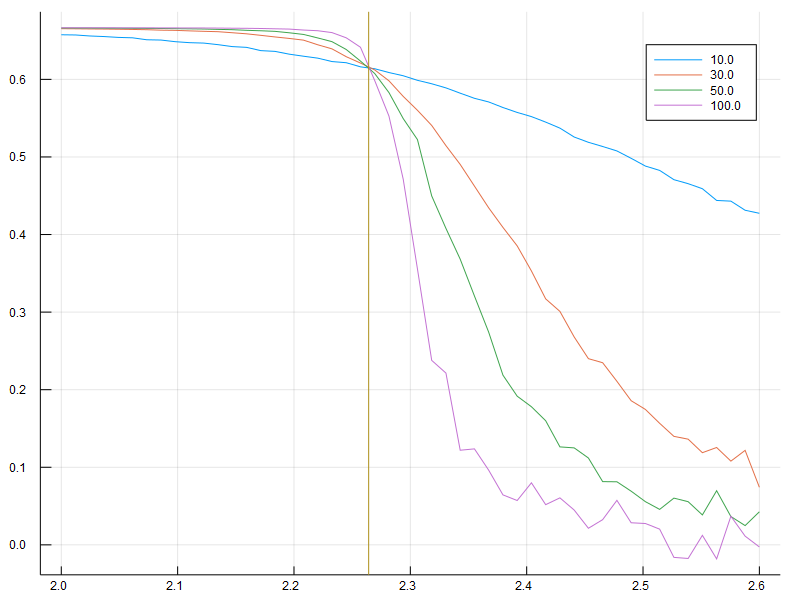

In [27]:
@df obs plot(:T, 1.-:m4./3./:m2.^2, group=:L, marker=(:auto, 0.),size=(800,600))
vline!([Tc-0.005], lab="")